In [1]:
import pandas as pd
import numpy as np
import os
import neurokit2 as nk
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import gc
from scipy import stats
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]  # Bigger images

In [3]:
def get_experiment_start(path):

    with open(path, 'r+') as f:
        for line in f.readlines():
            if line.startswith('#Recording time'):
                timestamp_str = line.replace('#Recording time,Date: ', '')
                timestamp_str = timestamp_str[:timestamp_str.find(',Unix time:')]
                break

    try:
        ts = pd.to_datetime(timestamp_str,
                        format="%d.%m.%Y,Time: %H:%M:%S.%f +02:00")
    except:
        ts = pd.to_datetime(timestamp_str,
                            format="%m/%d/%Y,Time: %H:%M:%S.%f +02:00")
    ts = ts - timedelta(hours=2)
    nanoseconds = int(ts.value)
    return nanoseconds

In [4]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  
empatica_folder_path = '/Users/annapalatkina/Desktop/drive/Embrace Plus/participant_data_csv'

data_full = pd.DataFrame(columns=['miliseconds', 'EDA',  'EventLabel', 'Participant'])

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv') and filename!='N7P5B8G0.csv': 
        print(filename)
        experiment_start_nanoseconds = get_experiment_start(file_path)
        participant_id = filename.split('.')[0]
        data_imotions = pd.read_csv(file_path, comment='#',low_memory=False, usecols=['Row','Timestamp','MarkerName','MarkerType'])
        data_empatica = pd.read_csv(os.path.join(empatica_folder_path,participant_id,'electrodermalActivity_data_embrace.csv'))
        
        data_empatica['miliseconds'] = [(pd.to_datetime(i).value - experiment_start_nanoseconds) / (10**6) for i in data_empatica['time_iso']]
        data_empatica = data_empatica.sort_values(by='miliseconds')

        start = data_imotions.query('MarkerName == "Experiment" and MarkerType == "S"').Timestamp.values[0]
        end = data_imotions.query('MarkerName == "Experiment" and MarkerType == "E"').Timestamp.values[0]
        data_empatica = data_empatica.query('@start <= miliseconds <= @end')

        markers = list(data_imotions[data_imotions['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data_empatica['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "S")].Timestamp.values[0]
            end = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "E")].Timestamp.values[0]
            idx = data_empatica.query('@start <= miliseconds <= @end').index
            data_empatica.loc[idx, 'EventLabel'] = data_empatica.loc[idx, 'EventLabel'].fillna(m)

        data_empatica['EventLabel'] = data_empatica['EventLabel'].fillna('Silence')
        data_empatica['Participant'] = [participant_id] * len(data_empatica)
        data_full = pd.concat([data_full, data_empatica], ignore_index=True)
        del data_empatica
        gc.collect()



I8L4N6G7.csv


/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_29901/3326903690.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_full = pd.concat([data_full, data_empatica], ignore_index=True)


M0R6U5F9.csv
D0P7X9W6.csv
M7D3F5K4.csv
O4A0U8R1.csv
V9L0P2K7.csv
M4H6R2W9.csv
U6O5V2T9.csv
G9K4W1Z0.csv
J6W7Q4H5.csv
J4X1T0D2.csv
Z6A2W1E8.csv
L0S1Z2I3.csv
C1K4L9S8.csv
X5Q0G4J2.csv
K4G7Y9O2.csv


In [5]:
data_full

,miliseconds,EDA,EventLabel,Participant,time_iso,samplingFrequencyEDA,file_name,Participant_ID
0,10656.974,0.183283,Silence,I8L4N6G7,2025-05-20 10:09:16.784974,4.000271,1-1-I8L4N6G7_1747733961.avro,1-1-I8L4N6G7
1,10906.974,0.181575,Silence,I8L4N6G7,2025-05-20 10:09:17.034974,4.000271,1-1-I8L4N6G7_1747733961.avro,1-1-I8L4N6G7
2,11156.974,0.180707,Silence,I8L4N6G7,2025-05-20 10:09:17.284974,4.000271,1-1-I8L4N6G7_1747733961.avro,1-1-I8L4N6G7
3,11406.974,0.180892,Silence,I8L4N6G7,2025-05-20 10:09:17.534974,4.000271,1-1-I8L4N6G7_1747733961.avro,1-1-I8L4N6G7
4,11656.974,0.181561,Silence,I8L4N6G7,2025-05-20 10:09:17.784974,4.000271,1-1-I8L4N6G7_1747733961.avro,1-1-I8L4N6G7
...,...,...,...,...,...,...,...,...
57417,932538.052,0.007909,Silence,K4G7Y9O2,2025-05-19 09:54:34.822052,4.000344,1-1-K4G7Y9O2_1747647109.avro,1-1-K4G7Y9O2
57418,932788.052,0.008236,Silence,K4G7Y9O2,2025-05-19 09:54:35.072052,4.000344,1-1-K4G7Y9O2_1747647109.avro,1-1-K4G7Y9O2
57419,933038.052,0.007539,Silence,K4G7Y9O2,2025-05-19 09:54:35.322052,4.000344,1-1-K4G7Y9O2_1747647109.avro,1-1-K4G7Y9O2
57420,933288.052,0.008492,Silence,K4G7Y9O2,2025-05-19 09:54:35.572052,4.000344,1-1-K4G7Y9O2_1747647109.avro,1-1-K4G7Y9O2


In [6]:
data_full.Participant.value_counts()

Participant
J4X1T0D2    3601
D0P7X9W6    3600
M7D3F5K4    3600
O4A0U8R1    3600
V9L0P2K7    3600
M4H6R2W9    3600
G9K4W1Z0    3600
J6W7Q4H5    3600
Z6A2W1E8    3600
L0S1Z2I3    3600
C1K4L9S8    3600
X5Q0G4J2    3600
K4G7Y9O2    3600
U6O5V2T9    3568
I8L4N6G7    3561
M0R6U5F9    3492
Name: count, dtype: int64

In [7]:
data_full.EventLabel.value_counts()

EventLabel
Silence         19421
IntenseAudio    17412
CalmAudio       17382
InterimAudio     3207
Name: count, dtype: int64

In [8]:
mask_silence = (data_full["EventLabel"] == "Silence")
mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")
mask_music = (data_full["EventLabel"] == "InterimAudio")

positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines = data_full[mask_silence]

In [33]:
def extract_eda_info(df):
    n_peaks = []
    ampl_peaks = []
    participants = []

    for participant, data in df.groupby(by='Participant'):
        sampling_rate = data.samplingFrequencyEDA.iloc[0]
        signal, _= nk.eda_process(data.EDA, sampling_rate=sampling_rate)
        n_peaks.append(sum(signal.SCR_Peaks))
        ampl_peaks.append(np.mean(signal.query('SCR_Peaks ==1').SCR_Amplitude))
        participants.append(participant)

    return n_peaks,  ampl_peaks, participants 

n_peaks_pos, ampl_peaks_pos, participants = extract_eda_info(positives)
n_peaks_neg, ampl_peaks_neg, participants = extract_eda_info(negatives)
n_peaks_bas, ampl_peaks_bas, participants = extract_eda_info(baselines)

/Users/annapalatkina/Desktop/drive/.venv/lib/python3.10/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/annapalatkina/Desktop/drive/.venv/lib/python3.10/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/annapalatkina/Desktop/drive/.venv/lib/python3.10/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/annapalatkina/Desktop/drive/.venv/lib/python3.10/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/annapalatkina/Desktop/drive/.venv/lib/python3.10/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/annapalatkina/Desktop/drive/.venv

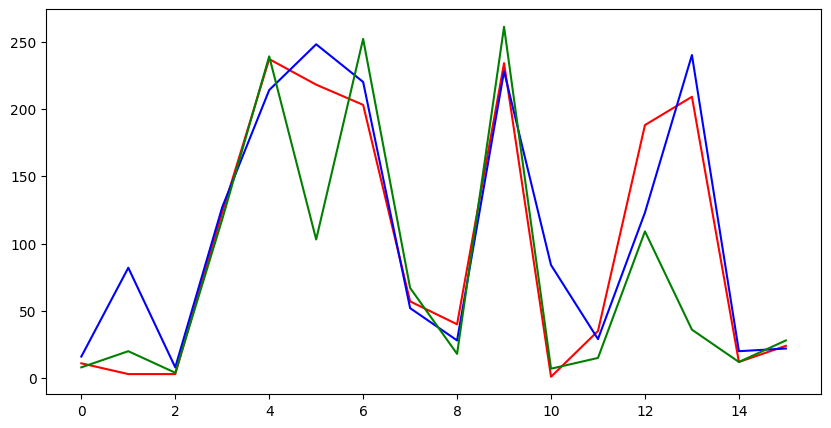

In [48]:
plt.plot(n_peaks_pos, 'r') # plotting t, a separately 
plt.plot(n_peaks_neg, 'b') # plotting t, b separately 
plt.plot(n_peaks_bas, 'g') # plotting t, c separately 
plt.show()

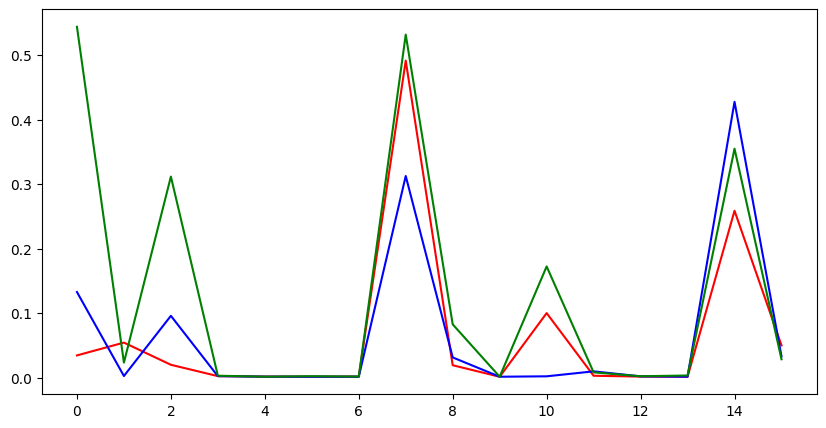

In [49]:
plt.plot(ampl_peaks_pos, 'r') # plotting t, a separately 
plt.plot(ampl_peaks_neg, 'b') # plotting t, b separately 
plt.plot(ampl_peaks_bas, 'g') # plotting t, c separately 
plt.show()

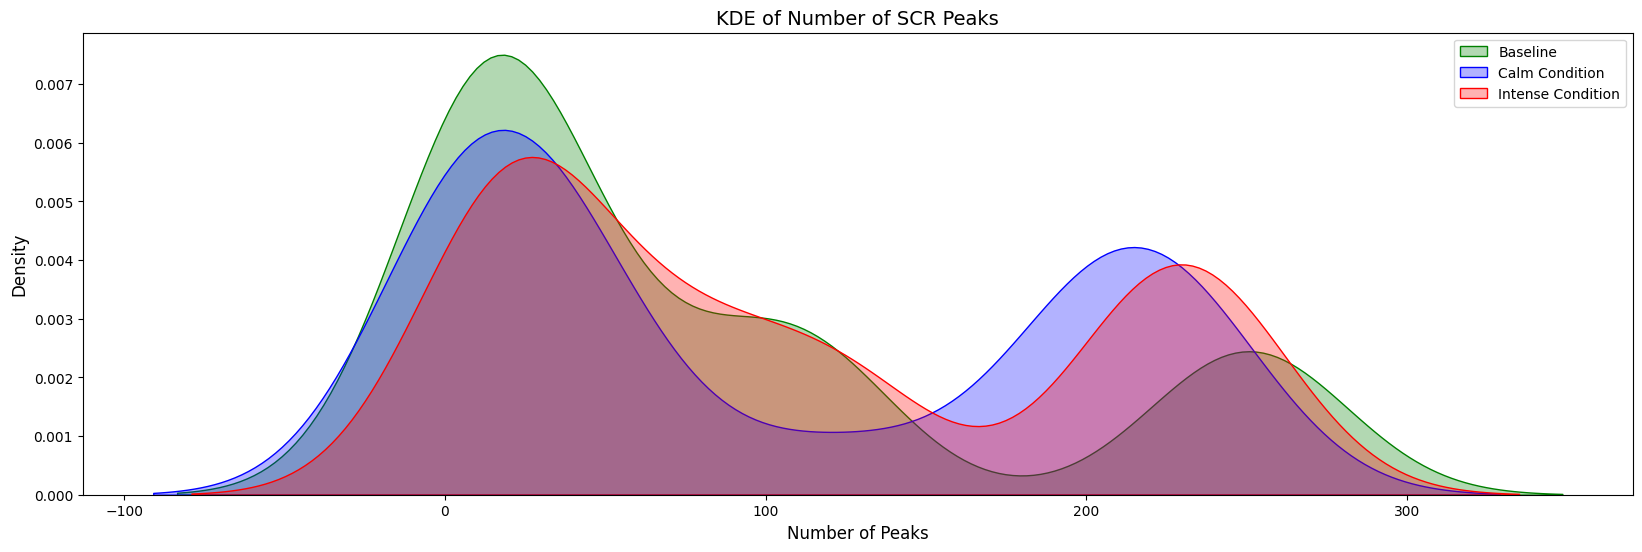

In [ ]:
plt.figure(figsize=(20, 6))
sns.kdeplot(n_peaks_bas, label='Baseline', color='green', fill=True, alpha=0.3, bw_adjust=.55)
sns.kdeplot(n_peaks_pos, label='Calm Condition', color='blue', fill=True, alpha=0.3, bw_adjust=.55)
sns.kdeplot(n_peaks_neg, label='Intense Condition', color='red', fill=True, alpha=0.3, bw_adjust=.55)
plt.title('KDE of Number of SCR Peaks', fontsize=14)
plt.xlabel('Number of Peaks', fontsize=12)
plt.ylabel('Density', fontsize=12)
#plt.xlim(0, 15)  # Set x-axis limit based on data range
plt.legend()
plt.show()

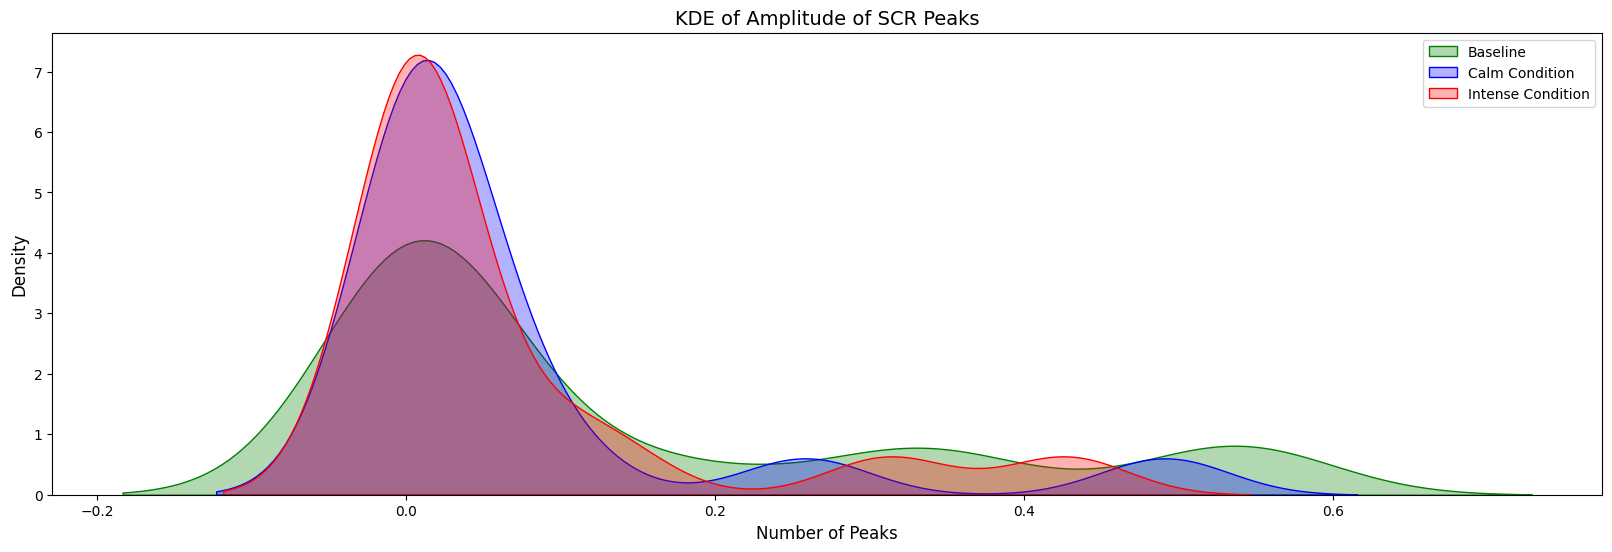

In [52]:
plt.figure(figsize=(20, 6))
sns.kdeplot(ampl_peaks_bas, label='Baseline', color='green', fill=True, alpha=0.3, bw_adjust=.55)
sns.kdeplot(ampl_peaks_pos, label='Calm Condition', color='blue', fill=True, alpha=0.3, bw_adjust=.55)
sns.kdeplot(ampl_peaks_neg, label='Intense Condition', color='red', fill=True, alpha=0.3, bw_adjust=.55)
plt.title('KDE of Amplitude of SCR Peaks', fontsize=14)
plt.xlabel('Number of Peaks', fontsize=12)
plt.ylabel('Density', fontsize=12)
#plt.xlim(0, 15)  # Set x-axis limit based on data range
plt.legend()
plt.show()

In [44]:
np.random.seed(42)  # For reproducibility
n_participants = len(n_peaks_pos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline': ampl_peaks_bas,  
    'Positive': ampl_peaks_pos,
    'Negative': ampl_peaks_neg
}
df = pd.DataFrame(data)

# Long format for repeated measures ANOVA
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')
ps = []

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    ps.append(p >= 0.05)
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline: statistic=0.700, p=0.000
  Baseline is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive: statistic=0.558, p=0.000
  Positive is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative: statistic=0.594, p=0.000
  Negative is not normally distributed (p < 0.05)


Doing Friedman

Friedman Test Results:
Chi-square=1.556, p=0.459


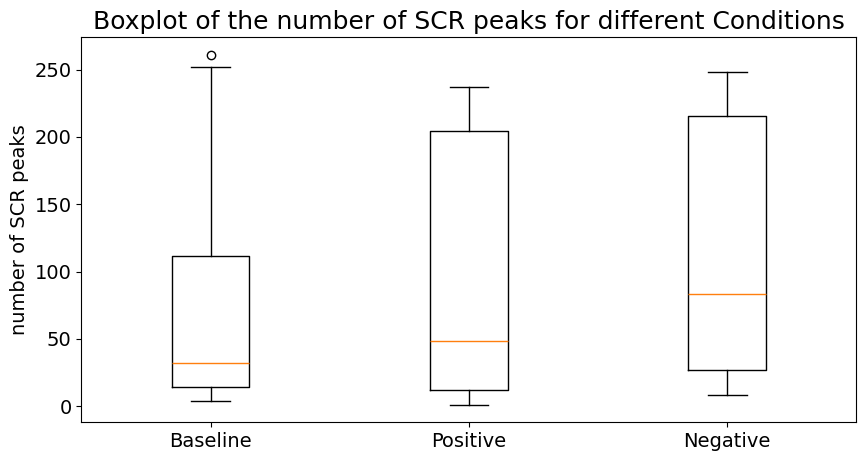

In [21]:
# 2. Choose and run the test
if all(ps):  # All normal
    print('Doing anova')
    # Repeated Measures ANOVA
    anova = pg.rm_anova(data=df_long, dv='Slope', within='Condition', subject='Participant')
    print("\nRepeated Measures ANOVA Results:")
    print(anova)
    if anova['p-unc'][0] < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc tests...")
        # Post-hoc paired t-tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                t_stat, p_val = stats.ttest_rel(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2  # Bonferroni
                print(f"Paired t-test {cond1} vs {cond2}: t={t_stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")
else:
    print('Doing Friedman')
    # Friedman Test (non-parametric)
    stat, p = stats.friedmanchisquare(df['Baseline'], df['Positive'], df['Negative'])
    print("\nFriedman Test Results:")
    print(f"Chi-square={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc Wilcoxon tests...")
        # Post-hoc Wilcoxon Signed-Rank tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2
                print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")

# Optional: Visualize the data
plt.boxplot([df['Baseline'], df['Positive'], df['Negative']], tick_labels=['Baseline', 'Positive', 'Negative'])
plt.title('Boxplot of the number of SCR peaks for different Conditions', fontsize=18)
plt.ylabel('number of SCR peaks', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [22]:
from scipy.stats import wilcoxon
# compare samples
stat, p = wilcoxon( df['Positive'], df['Negative'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=52.000, p=0.408
Same distribution (fail to reject H0)


In [56]:
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1, cond2 = conditions[i], conditions[j]
        stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
        p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2
        print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")

Wilcoxon Baseline vs Positive: statistic=23.000, p=0.018, adjusted p=0.055
Wilcoxon Baseline vs Negative: statistic=30.000, p=0.051, adjusted p=0.152
Wilcoxon Positive vs Negative: statistic=64.000, p=0.860, adjusted p=2.581


In [23]:
np.random.seed(42)  # For reproducibility
n_participants = len(ampl_peaks_pos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline': ampl_peaks_bas,  
    'Positive': ampl_peaks_pos,
    'Negative': ampl_peaks_neg
}
df = pd.DataFrame(data)

# Long format for repeated measures ANOVA
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')
ps = []

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    ps.append(p >= 0.05)
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline: statistic=0.700, p=0.000
  Baseline is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive: statistic=0.558, p=0.000
  Positive is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative: statistic=0.594, p=0.000
  Negative is not normally distributed (p < 0.05)


Doing Friedman

Friedman Test Results:
Chi-square=6.000, p=0.050
Significant difference found (p < 0.05). Performing post-hoc Wilcoxon tests...
Wilcoxon Baseline vs Positive: statistic=23.000, p=0.018, adjusted p=0.055
Wilcoxon Baseline vs Negative: statistic=30.000, p=0.051, adjusted p=0.152
Wilcoxon Positive vs Negative: statistic=64.000, p=0.860, adjusted p=2.581


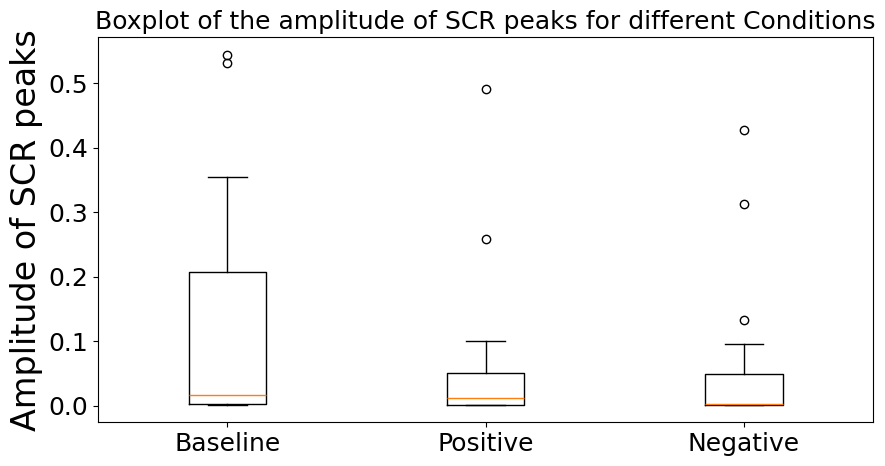

In [24]:
# 2. Choose and run the test
if all(ps):  # All normal
    print('Doing anova')
    # Repeated Measures ANOVA
    anova = pg.rm_anova(data=df_long, dv='Slope', within='Condition', subject='Participant')
    print("\nRepeated Measures ANOVA Results:")
    print(anova)
    if anova['p-unc'][0] < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc tests...")
        # Post-hoc paired t-tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                t_stat, p_val = stats.ttest_rel(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2  # Bonferroni
                print(f"Paired t-test {cond1} vs {cond2}: t={t_stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")
else:
    print('Doing Friedman')
    # Friedman Test (non-parametric)
    stat, p = stats.friedmanchisquare(df['Baseline'], df['Positive'], df['Negative'])
    print("\nFriedman Test Results:")
    print(f"Chi-square={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc Wilcoxon tests...")
        # Post-hoc Wilcoxon Signed-Rank tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2
                print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")

# Optional: Visualize the data
plt.boxplot([df['Baseline'], df['Positive'], df['Negative']], tick_labels=['Baseline', 'Positive', 'Negative'])
plt.title('Boxplot of the amplitude of SCR peaks for different Conditions', fontsize=18)
plt.ylabel('Amplitude of SCR peaks', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [25]:
from scipy.stats import wilcoxon
# compare samples
stat, p = wilcoxon( df['Positive'], df['Negative'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=64.000, p=0.860
Same distribution (fail to reject H0)


In [57]:
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1, cond2 = conditions[i], conditions[j]
        stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
        p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2
        print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")

Wilcoxon Baseline vs Positive: statistic=23.000, p=0.018, adjusted p=0.055
Wilcoxon Baseline vs Negative: statistic=30.000, p=0.051, adjusted p=0.152
Wilcoxon Positive vs Negative: statistic=64.000, p=0.860, adjusted p=2.581


# OLD

In [9]:
data_empatica = pd.read_csv('/Users/annapalatkina/Desktop/drive/Embrace Plus/participant_data_csv/M7D3F5K4/electrodermalActivity_data_embrace.csv')

data_empatica

,time_iso,samplingFrequencyEDA,EDA,file_name,Participant_ID
0,2025-05-20 14:35:18.567386,4.000368,0.136215,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4
1,2025-05-20 14:35:18.817386,4.000368,0.137596,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4
2,2025-05-20 14:35:19.067386,4.000368,0.137553,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4
3,2025-05-20 14:35:19.317386,4.000368,0.137169,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4
4,2025-05-20 14:35:19.567386,4.000368,0.146476,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4
...,...,...,...,...,...
5303,2025-05-20 14:57:24.317386,4.000368,1.659862,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4
5304,2025-05-20 14:57:24.567386,4.000368,1.657329,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4
5305,2025-05-20 14:57:24.817386,4.000368,1.652390,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4
5306,2025-05-20 14:57:25.067386,4.000368,1.638160,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4


In [10]:
with open('/Users/annapalatkina/Desktop/drive/participants/M7D3F5K4.csv', 'r+') as f:
    for line in f.readlines():
      if line.startswith('#Respondent Gender'):
        gender = line.replace('#Respondent Gender,','').strip().replace(',','')
      if line.startswith('#Respondent Age'):
        age = int(line.replace('#Respondent Age,','').strip().replace(',',''))
      if line.startswith('#Recording time'):
        timestamp_str = line.replace('#Recording time,Date: ', '')
        timestamp_str = timestamp_str[:timestamp_str.find(',Unix time:')]
        break

try:
    ts = pd.to_datetime(timestamp_str,
                    format="%d.%m.%Y,Time: %H:%M:%S.%f +02:00")
except:
    ts = pd.to_datetime(timestamp_str,
                        format="%m/%d/%Y,Time: %H:%M:%S.%f +02:00")
    ts = ts - timedelta(hours=2)

    nanoseconds = int(ts.value)

In [11]:
ts,  nanoseconds

(Timestamp('2025-05-20 14:41:24.497000'), 1747752084497000000)

In [12]:
data_imotions = pd.read_csv('/Users/annapalatkina/Desktop/drive/participants/C1K4L9S8.csv', comment='#')[['Row',	'Timestamp',  'MarkerName', 'MarkerType']]
data_imotions[data_imotions['MarkerName'].notna()].sort_values('Row')

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_16221/1575380146.py:1: DtypeWarning: Columns (3,4,6,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data_imotions = pd.read_csv('/Users/annapalatkina/Desktop/drive/participants/C1K4L9S8.csv', comment='#')[['Row',	'Timestamp',  'MarkerName', 'MarkerType']]


,Row,Timestamp,MarkerName,MarkerType
1607,1608,5135.9521,Experiment,S
90385,90386,215286.1970,IntenseAudio,S
193505,193506,487827.0899,InterimAudio,S
193506,193507,487827.0899,IntenseAudio,E
212201,212202,537715.2276,CalmAudio,S
212202,212203,537715.2276,InterimAudio,E
313282,313283,809406.2262,CalmAudio,E
348626,348627,905132.6988,Experiment,E


In [13]:
data_empatica['nanoseconds'] = [pd.to_datetime(x).value for x in data_empatica['time_iso']]

start_experiment_nanoseconds = nanoseconds
data_empatica['miliseconds'] = [(i - start_experiment_nanoseconds) / (10**6) for i in data_empatica['nanoseconds']]
data_empatica 

,time_iso,samplingFrequencyEDA,EDA,file_name,Participant_ID,nanoseconds,miliseconds
0,2025-05-20 14:35:18.567386,4.000368,0.136215,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747751718567386000,-365929.614
1,2025-05-20 14:35:18.817386,4.000368,0.137596,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747751718817386000,-365679.614
2,2025-05-20 14:35:19.067386,4.000368,0.137553,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747751719067386000,-365429.614
3,2025-05-20 14:35:19.317386,4.000368,0.137169,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747751719317386000,-365179.614
4,2025-05-20 14:35:19.567386,4.000368,0.146476,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747751719567386000,-364929.614
...,...,...,...,...,...,...,...
5303,2025-05-20 14:57:24.317386,4.000368,1.659862,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747753044317386000,959820.386
5304,2025-05-20 14:57:24.567386,4.000368,1.657329,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747753044567386000,960070.386
5305,2025-05-20 14:57:24.817386,4.000368,1.652390,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747753044817386000,960320.386
5306,2025-05-20 14:57:25.067386,4.000368,1.638160,1-1-M7D3F5K4_1747751718.avro,1-1-M7D3F5K4,1747753045067386000,960570.386


In [10]:
data_imotions[data_imotions['MarkerName'].notna()].sort_values('Row')

,Row,Timestamp,MarkerName,MarkerType
1607,1608,5135.9521,Experiment,S
90385,90386,215286.1970,IntenseAudio,S
193505,193506,487827.0899,InterimAudio,S
193506,193507,487827.0899,IntenseAudio,E
212201,212202,537715.2276,CalmAudio,S
212202,212203,537715.2276,InterimAudio,E
313282,313283,809406.2262,CalmAudio,E
348626,348627,905132.6988,Experiment,E


In [ ]:
data_empatica = data_empatica.sort_values(by='miliseconds')

start = data_imotions.query('MarkerName == "Experiment" and MarkerType == "S"').Timestamp.values[0]
end = data_imotions.query('MarkerName == "Experiment" and MarkerType == "E"').Timestamp.values[0]
data_empatica = data_empatica.query('@start <= miliseconds <= @end')

markers = list(data_imotions[data_imotions['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
markers.remove('Experiment')
data_empatica['EventLabel'] = pd.Series(dtype='object')
for i,m in enumerate(markers):
    start = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "S")].Timestamp.values[0]
    end = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "E")].Timestamp.values[0]
    idx = data_empatica.query('@start <= miliseconds <= @end').index
    data_empatica.loc[idx, 'EventLabel'] = data_empatica.loc[idx, 'EventLabel'].fillna(m)

data_empatica['EventLabel'] = data_empatica['EventLabel'].fillna('Silence')

['IntenseAudio', 'InterimAudio', 'CalmAudio']


In [33]:
data_empatica

,time_iso,samplingFrequencyEDA,EDA,file_name,Participant_ID,nanoseconds,miliseconds,EventLabel
2480,2025-05-27 12:41:14.171413,4.000311,7.822669,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748349674171413000,5276.413,Silence
2481,2025-05-27 12:41:14.421413,4.000311,7.820633,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748349674421413000,5526.413,Silence
2482,2025-05-27 12:41:14.671413,4.000311,7.815411,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748349674671413000,5776.413,Silence
2483,2025-05-27 12:41:14.921413,4.000311,7.813703,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748349674921413000,6026.413,Silence
2484,2025-05-27 12:41:15.171413,4.000311,7.811526,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748349675171413000,6276.413,Silence
...,...,...,...,...,...,...,...,...
6075,2025-05-27 12:56:12.921413,4.000311,3.119565,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748350572921413000,904026.413,Silence
6076,2025-05-27 12:56:13.171413,4.000311,3.118227,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748350573171413000,904276.413,Silence
6077,2025-05-27 12:56:13.421413,4.000311,3.116733,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748350573421413000,904526.413,Silence
6078,2025-05-27 12:56:13.671413,4.000311,3.114513,1-1-C1K4L9S8_1748349053.avro,1-1-C1K4L9S8,1748350573671413000,904776.413,Silence
